In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import sys
sys.path.append('../src')
import xgboost as xgb
import pandas as pd
from features.UserJoin import UserJoin
from features.UserJoin import submit, diff, plt_month, plt_day, load_ids
import config as C
import matplotlib.pyplot as plt
import plotly.express as px

/opt/conda/envs/miner/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# data
ds = UserJoin()

In [114]:
# from pathlib import Path
# import numpy as np 

# def info(f):
#     for i in Path('submit_csv').glob('*.csv'):
#         diff(f, i.name) 

In [53]:
month = ds.month[C.month_features + ['IS_FLAG', 'label']]
user = ds.train[C.user_features]

In [73]:
# 把测试集 550 个之外的，都标为 0。可以标 14827个用户。虽然其中有2个实际是挖矿用户。但比例很小，应该无所谓。好处更大
def aug1(df):
    testids = load_ids('35.csv')
    df.loc[df.index.isin(testids), 'IS_FLAG'] = 0
    return df

In [74]:
user_about_month = [i for i in user.columns if i in month.columns]
monthjoin = month.join(user[user_about_month], rsuffix='_mean')

mean_cols = []
for i in monthjoin.columns:
    if 'mean' in i:
        monthjoin[i.replace('mean', 'sub_mean')] = monthjoin[i.replace('_mean', '')] - monthjoin[i]
        mean_cols.append(i)

monthjoin = monthjoin.drop(columns=mean_cols)

/opt/conda/envs/miner/lib/python3.8/site-packages/xgboost/data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[15:53:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0


<AxesSubplot:>

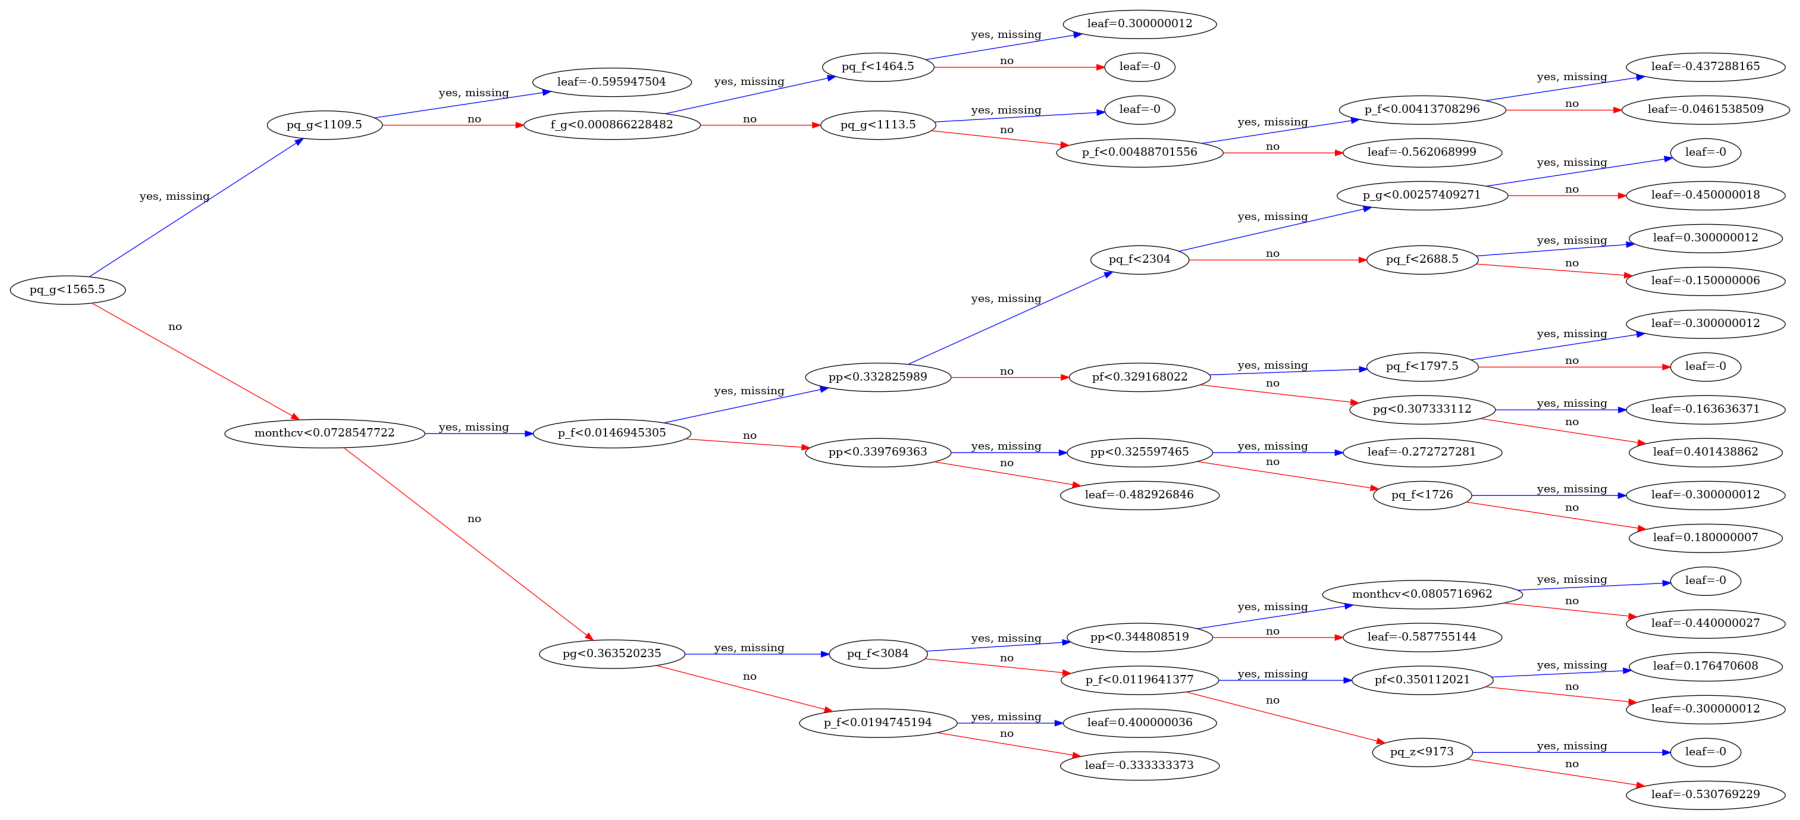

In [102]:
from xgboost import plot_tree
# df = monthjoin[monthjoin.index.isin(ds.train2.index.values)]
df = ds.rule3(month)
features = list(set(df.columns.values) - {'IS_FLAG', 'label'})
# print(features)

xy, x_val = df.loc[~df.IS_FLAG.isna(), features+['IS_FLAG']], df.loc[df.label == 'test', features]
x, y = xy.drop(columns=['IS_FLAG']), xy.IS_FLAG

model = xgb.XGBClassifier(use_label_encoder=False)
model.fit(x, y)
y_pred = model.predict(x)
print((y_pred != y).sum())
fig, ax = plt.subplots(figsize=(32, 16))
plot_tree(model, ax=ax, rankdir='LR')


In [103]:
pred = pd.DataFrame({'id': x.index.values, 'pred': y_pred.astype(int)}).groupby('id').sum()
pred[pred.pred > 0]

,pred
id,
329833811,21
1998335717,22
2294741747,16
2482675592,22
2614556942,22
2654985038,22
2674563661,22
2695447713,22
2816697143,22


In [121]:
from pathlib import Path
import numpy as np 

def info(f):
    s1, s2 = diff(f, 'submit_3_7_1.csv')
    return s1 ,s2

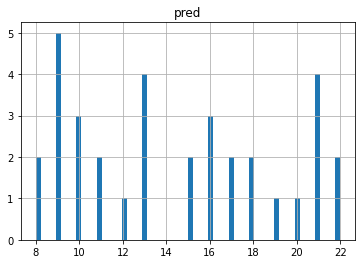

34
tsubmit.csv - submit_3_7_1.csv -> 1
submit_3_7_1.csv - tsubmit.csv ->  1
inner 33
0.9428571428571428


In [129]:
y_val = model.predict(x_val)
pred = pd.DataFrame({'id': x_val.index.values, 'pred': y_val}).groupby('id').sum()
pred = pred[pred.pred > 7]
pred.hist(bins=60)
plt.show()

submit(pred.index.unique(), 'tsubmit.csv')
s1, s2 = info('tsubmit.csv')

In [140]:
plt_month(list(s1-s2) + list(s2-s1), ds.month)

[2852503463, 2817362052]
